# สร้างข้อมูล sounding จาก ERA5 hourly 
* เนื่องจากวันที่เกิดเหตุการณ์พายุลูกเห็บที่เชียงของ ไม่มีข้อมูลตรวจอกาาศช้นบน จากสถานีเชียงใหม่ จึงต้องใช้ข้อมูลจากแบบจำลอง era 5 hourly โดยดูวิธีการและโค้ดจาก https://www.youtube.com/watch?v=C3YwOG8btMk เพื่อที่จะนำไปพลอตใน sharppy
* เชียงรายไม่มีการตรวจวัดสภาพอากาศชั้นบน มีแต่เชียงใหม่ แต่ก็ไม่ได้มีทุกวัน ให้ดูรายชื่อรหัสสถานีตรวจอากาศจากรายงาน wmo ได้ที่ลิงก์  https://library.wmo.int/doc_num.php?explnum_id=9896
* พิกัดภูมิศาสตร์ใช้บริเวณหาดไคร้ ต.เวียง อ.เชียงของ จังหวัดเชียงราย ได้มาจากกุเกิ้ล https://www.google.com/maps/place/Chiang+Khong+District,+Chiang+Rai/@20.2561247,100.4107162,2644m/data=!3m1!1e3!4m5!3m4!1s0x30d6372562c471b5:0x30346c5fa8a7370!8m2!3d20.1651266!4d100.3947116
* ลงโปรแกรม sharppy binary https://github.com/skovic/SHARPpy/releases/tag/v1.4.0-fixed
* ข้อมูล ERA5 hourly https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview


## ดาวน์โหลดข้อมูล era5 hourly วันที่ 24/04/2020 เวลา 0200UTC
* เนื่องจากอยากวิเคราะห์เวลา 1800 Local time เมื่อ + 7UTC (จริงๆ ต้อง - 7) เท่ากับ 2500 เท่ากับวันที่ 24 เมษายน 2020 เวลา 02 UTC
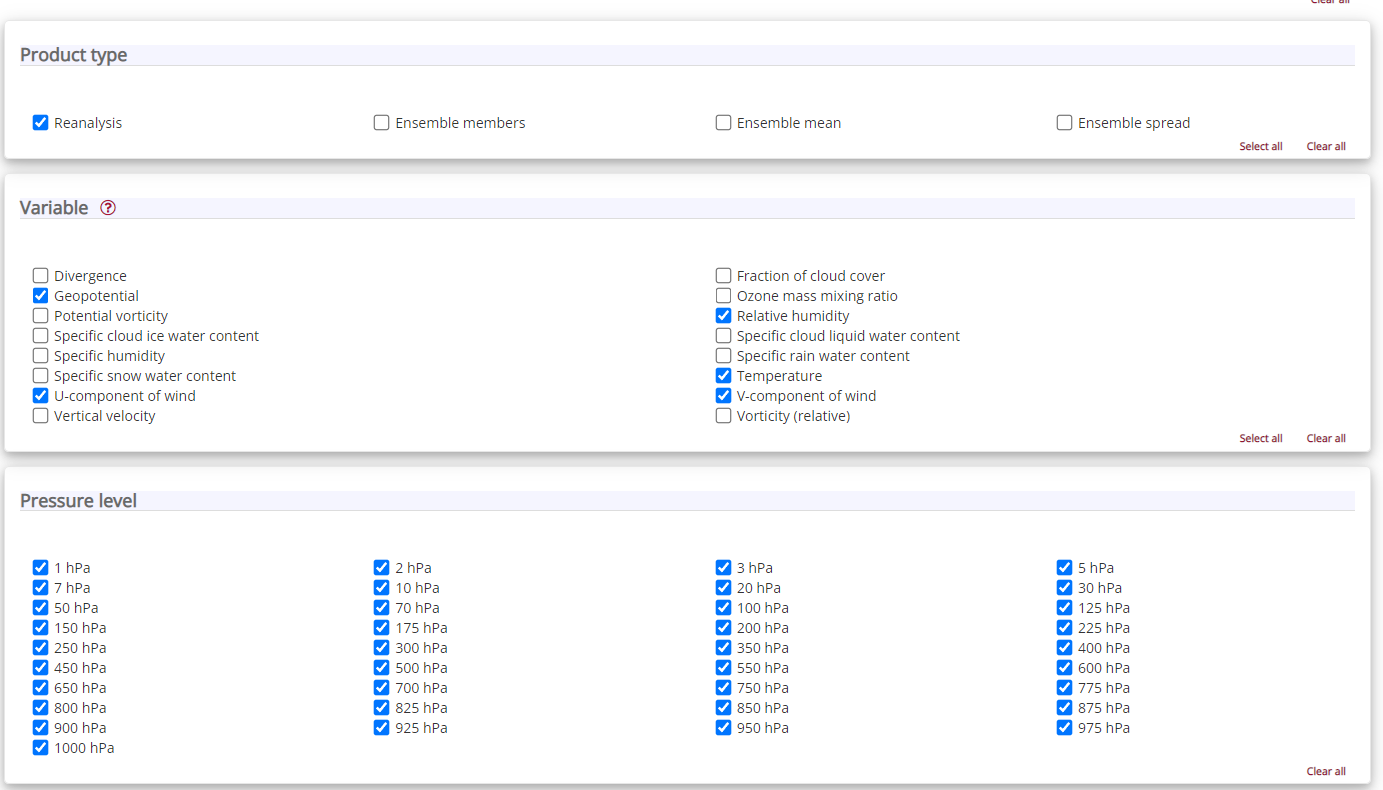

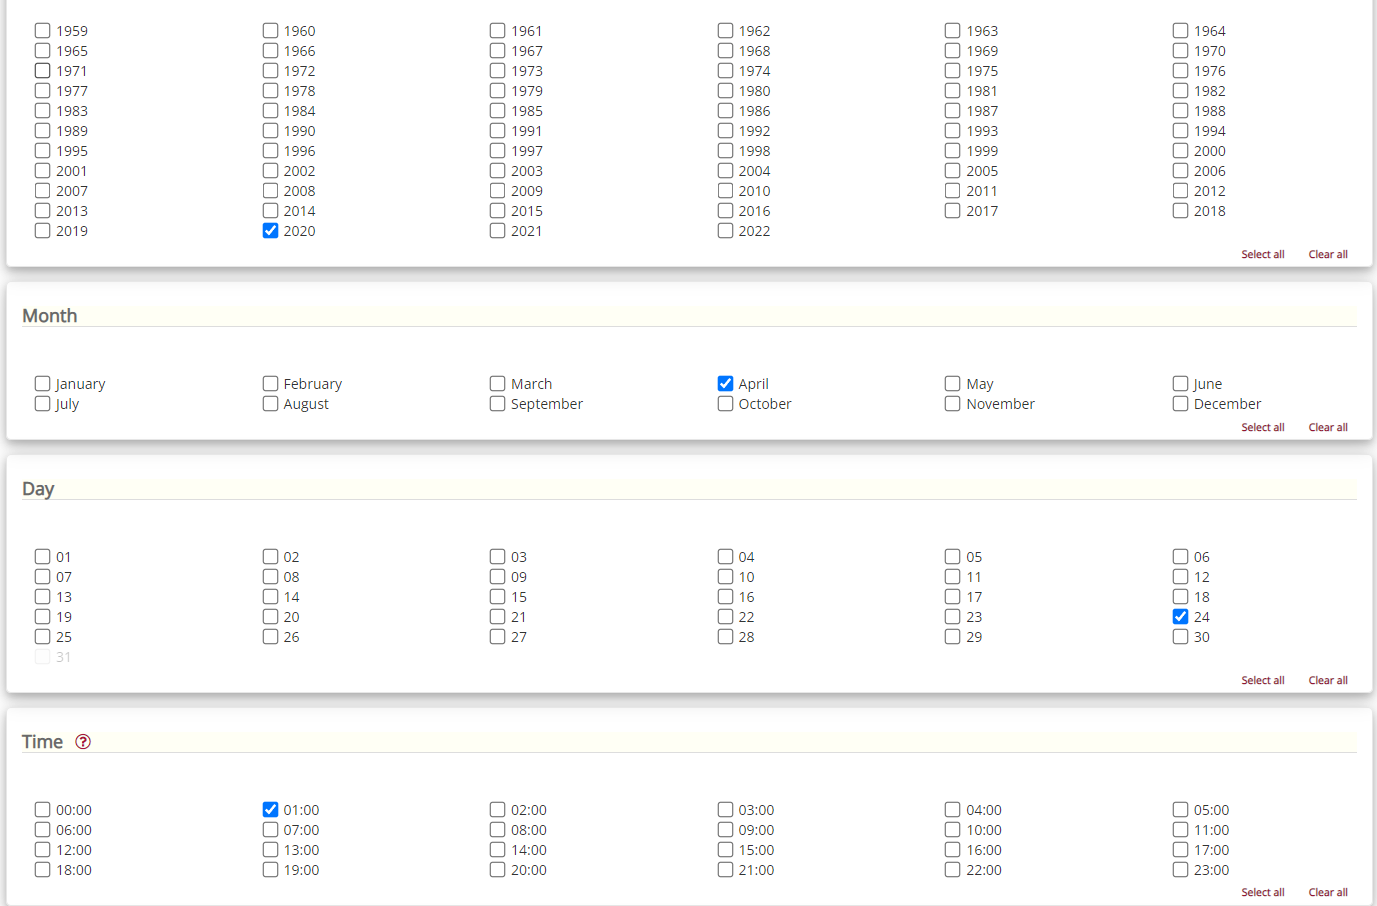

* ใช้ค่าพิกัดต.เวียง อ.เชียงของ จ.เชียงราย  ที่ได้จากกุเกิ้ล
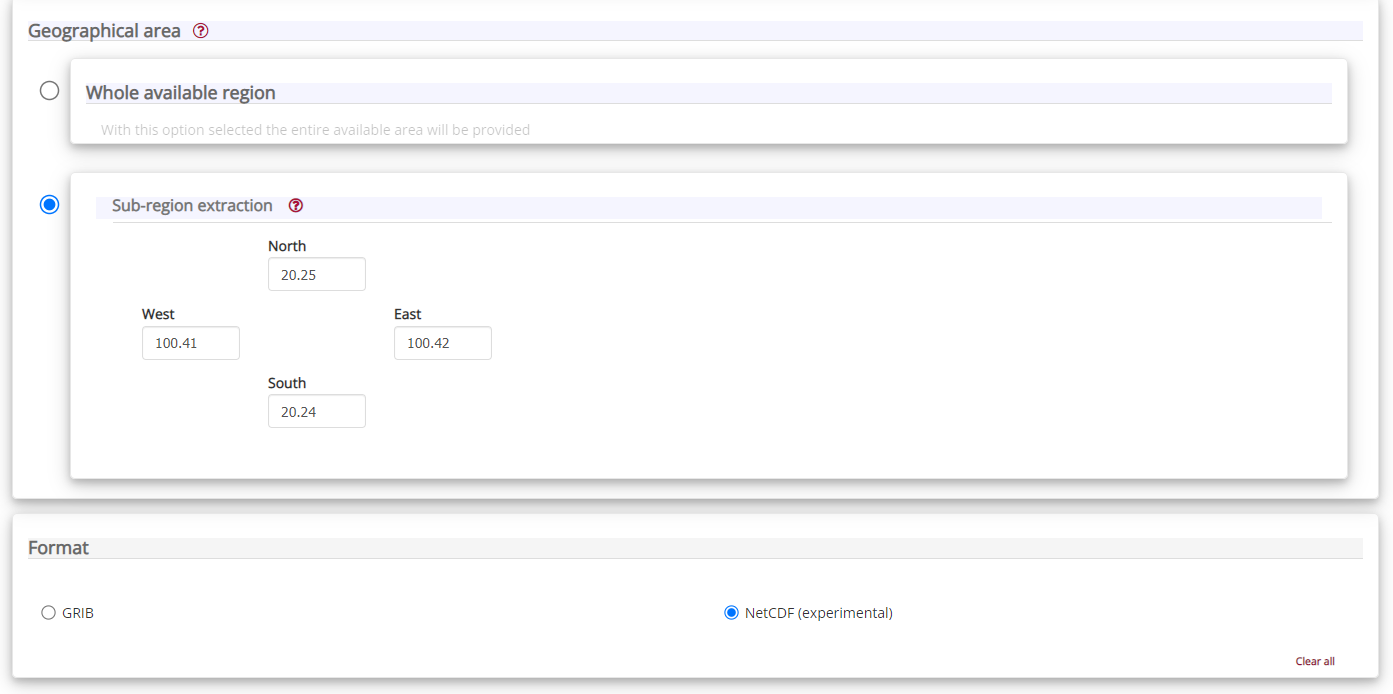


## โค้ดสกัดค่า reanalysis ตามพิกัดที่ต้องการ

In [1]:
from netCDF4 import Dataset
from metpy import calc
from metpy.units import units
import numpy as np

## อ่านค่าแบบจำลองที่สกัดมาได้

In [2]:
ds = Dataset('./1data/chiangkong_24042022_02UTC.nc')
lat = ds['latitude'][:]
lon = ds['longitude'][:]

## หาตำแหน่งที่ใกล้กับตำแหน่งที่ต้องการของหาดไคร้

In [3]:
c_x, c_y = 20.255734, 100.410341
x, y = np.abs(lat - c_x).argmin(), np.abs(lon + c_y).argmin()

## คำนวณค่าตัวแปรอุตุ

In [4]:
levels = ds['level'][:]
z = ds['z'][0, :, y, x] / 9.81
u = ds['u'][0, :, y, x]
v = ds['v'][0, :, y, x]
temp = ds['t'][0, :, y, x] - 273.15
rh = ds['r'][0, :, y, x]

## คำนวณทิศและความเร็วลม อุณหภูมิจุดน้ำค้าง

In [5]:
wdir = np.degrees(np.arctan2(u ,v)) + 180
dew = np.asarray(calc.dewpoint_from_relative_humidity(np.asarray(temp) * units.degC, np.asarray(rh) * units.percent))
wspd = np.hypot(u, v) * 1.944

## บันทึกไฟล์

In [6]:
with open('./2output/era5.txt', 'w', encoding = 'utf-8') as f:
    f.write(f"%TITLE%\nERA5   {str(2020)[2:]}{str(4).zfill(2)}{str(23).zfill(1)}/{str(2).zfill(11)}00\n-------------------------------------------------------------------\n%RAW%\n")

    for i in reversed(range(len(levels))):
        f.write(f'{levels[i]}, {z[i]},  {temp[i]}, {dew[i]}, {wdir[i]}, {wspd[i]}\n')

    f.write('%END%')

## ข้อมูลจากไฟล์  'era5.txt ' 
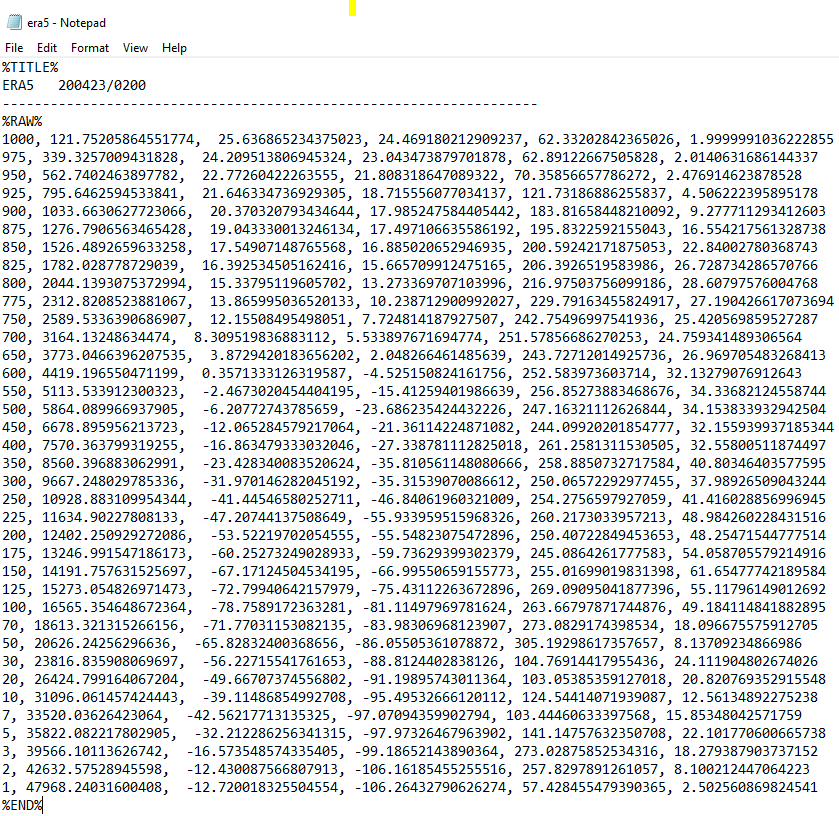

## ต่อไปจะนำไฟล์ 'era5.txt ' ไปเปิดด้วย sharppy

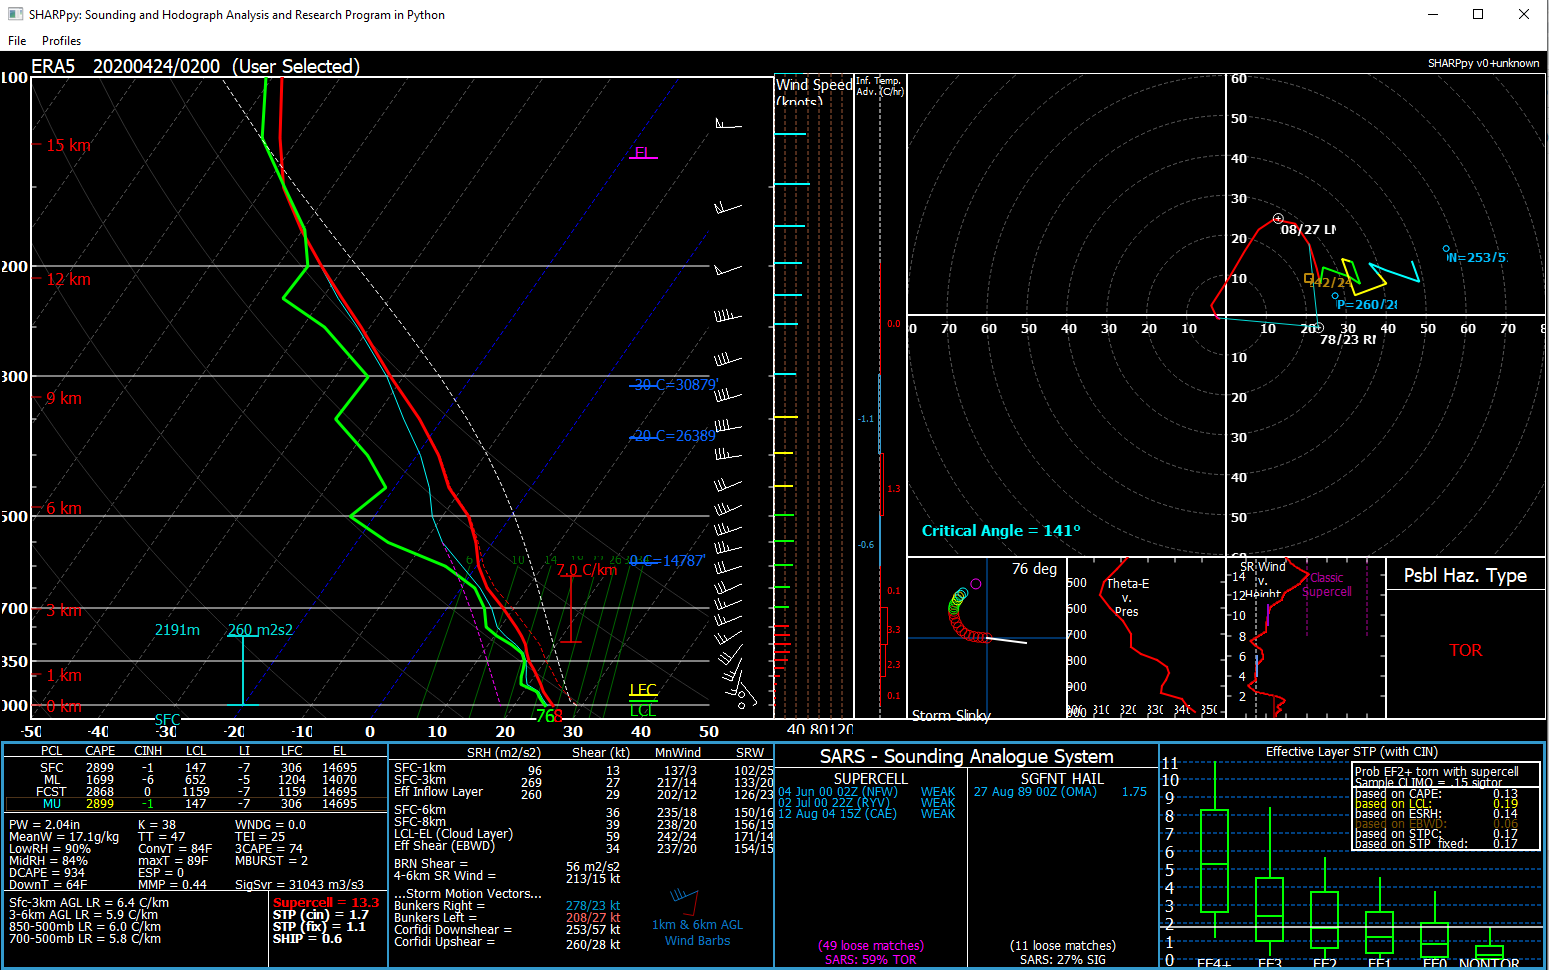